In [1]:
import glob
import math
import time
import operator
import cv2
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from tempfile import TemporaryFile
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

In [2]:
def normalize_gray_to_rgb(img):
    img *= 255.0 / img.max()
    img = np.expand_dims(img, 2)
    img = np.array(cv2.merge((img, img, img)), np.uint8)
    
    return img

def load_images(files, num=0):
    imgs = None
    files_sel = []
    
    if num == 0: 
        num = len(files)
        files_sel = files
    else:
        for i in range(num):
            idx = np.random.choice(len(files), 1)[0]
            files_sel.append(files[idx])
            
    for fname in files_sel:
        img = cv2.imread(fname)
        
        if imgs is None:
            imgs = np.empty([0, img.shape[0], img.shape[1], img.shape[2]], dtype = np.uint8)
            
        imgs = np.append(imgs, img[None,:], axis=0)
        
    return imgs

def display_image_set(imgs, filename, cols_num=6):
    height_init, width_init, _ = imgs[0].shape
    
    if width_init > 300:
        width_img = int(math.ceil(float(300) / float(cols_num)))
    else:
        width_img = width_init
        
    imgs_num = len(imgs)
    rows_num = int(math.ceil(float(imgs_num) / float(cols_num)))
    Kwidth = float(width_init) / float(width_img)
    height_img = int(height_init / Kwidth)
    result_shape = (rows_num * height_img, cols_num * width_img, 3)
    results_image = 255 * np.ones(shape=result_shape, dtype=np.uint8)

    for idx, img in enumerate(imgs):
        if img.shape[2] == 1:
            img = np.array(cv2.merge((img,img,img)),np.uint8)
            
        row = idx // cols_num
        col = idx - row * cols_num
        
        if width_init != width_img:
            img_resized = cv2.resize(img, (width_img, height_img), interpolation = cv2.INTER_AREA)
        else:
            img_resized = img
        
        h, w, _ = img_resized.shape
        origin_y = row * h
        origin_x = col * w
        results_image[origin_y:origin_y+h, origin_x:origin_x+w, :] = img_resized

    plt.rcParams["figure.figsize"] = (25, 25)
    cv2.imwrite('./preview/{}.jpg'.format(filename), cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
    plt.imshow(results_image.astype(np.uint8))
    plt.axis('off') 
    plt.show()

In [3]:
def to_colorspace(img, space='LUV'):
    if space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif space == 'gray':
        return np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 2)
    else: 
        return img
    
def bin_spatial(img, size=(32, 32)):
    channels = []
    
    for idx in img.shape[-1]:
        ch = cv2.resize(img[:,:,idx], size).ravel()
        channels.append(ch)
        
    return np.hstack(tuple(channels))
                        
def color_hist(img, nbins=32):
    channels = []
    
    for idx in img.shape[-1]:
        ch = np.histogram(img[:,:,idx], bins=nbins)
        channels.append(ch[0])

    return np.concatenate(tuple(channels))

def extract_hog(img, orient, ppc, cpb, vis=False, vec=False):
    return hog(
        img, 
        orientations=orient, 
        pixels_per_cell=(ppc, ppc), 
        cells_per_block=(cpb, cpb), 
        transform_sqrt=True, 
        visualise=vis, 
        feature_vector=vec
    )

def hog_features(img, space='LUV', orient=8, ppc=8, cpb=2, vis=False, vec=False):
    features = []
    previews = []
    img = to_colorspace(img, space)
    
    for idx in range(img.shape[-1]):
        hog = extract_hog(img[:,:,idx], orient, ppc, cpb, vis=vis, vec=vec)

        if vis:
            _, preview = hog
            preview = normalize_gray_to_rgb(preview)
            previews.append(preview)
        else:
            feature = hog
            features.append(feature)
    
    if vis:
        return np.array(previews).astype(np.uint8)
    else:
        return np.array(features).astype(np.float64)

def hogs_from_files(files):
    features = []

    for file in files:
        img = load_images([file])[0]
        feature_hogs = hog_features(img, vec=False)
        features.extend(feature_hogs)
    
    return features

def hog_preview(files):
    previews = []

    for file in files:
        img = load_images([file])[0]
        previews.append(img)
        preview_hogs = hog_features(img, vis=True)
        previews.extend(preview_hogs)
    
    return previews

def draw_boxes(img, bboxes, color=None, thick=6):
    for bbox in bboxes:
        if color is None:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [4]:
files_cars = glob.glob('./source_images/vehicles/**/*.png')
files_noncars = glob.glob('./source_images/non-vehicles/**/*.png')
print("Cars in dataset: {}; Non-cars in dataset: {}".format(len(files_cars), len(files_noncars)))

Cars in dataset: 8792; Non-cars in dataset: 8968


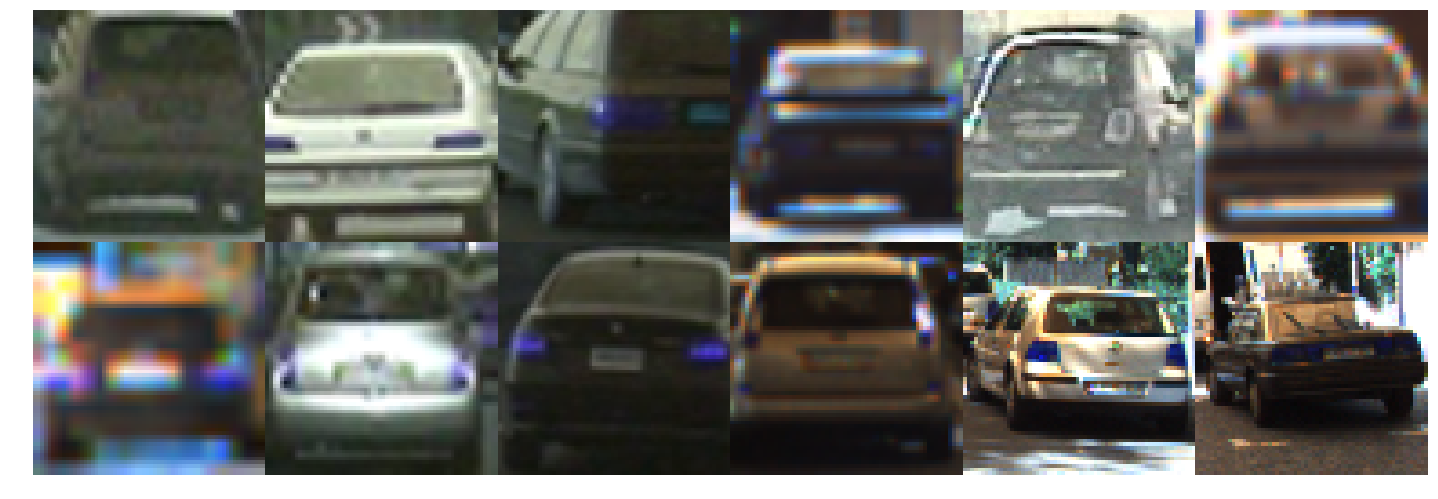

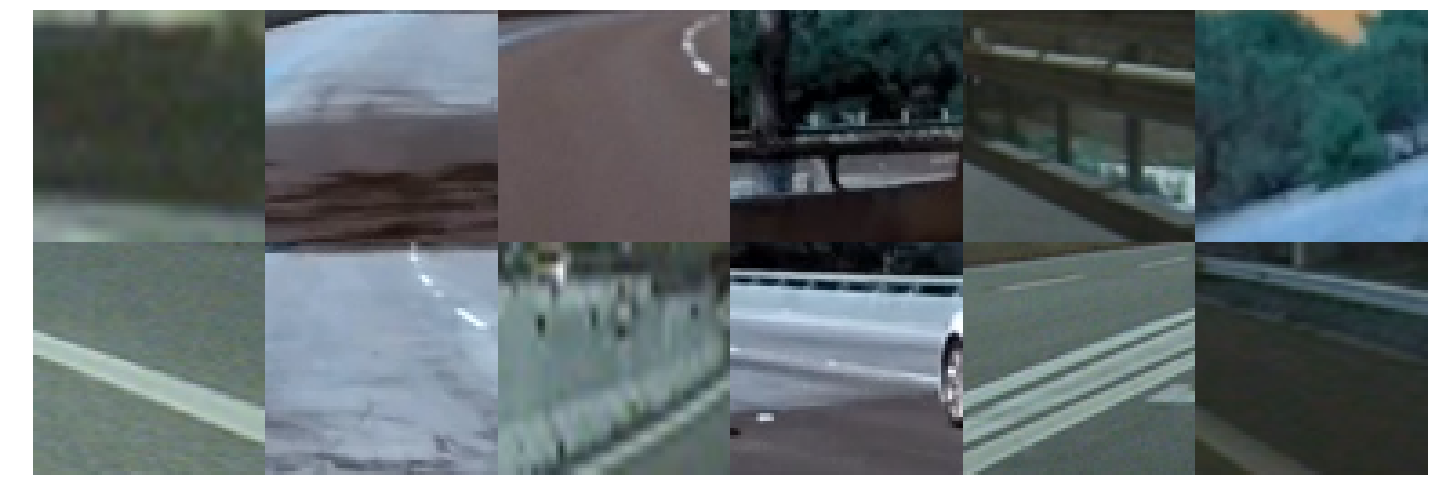

In [17]:
preview_cars = load_images(files_cars, num=12)
display_image_set(preview_cars, "cars")

preview_noncars = load_images(files_noncars, num=12)
display_image_set(preview_noncars, "noncars")

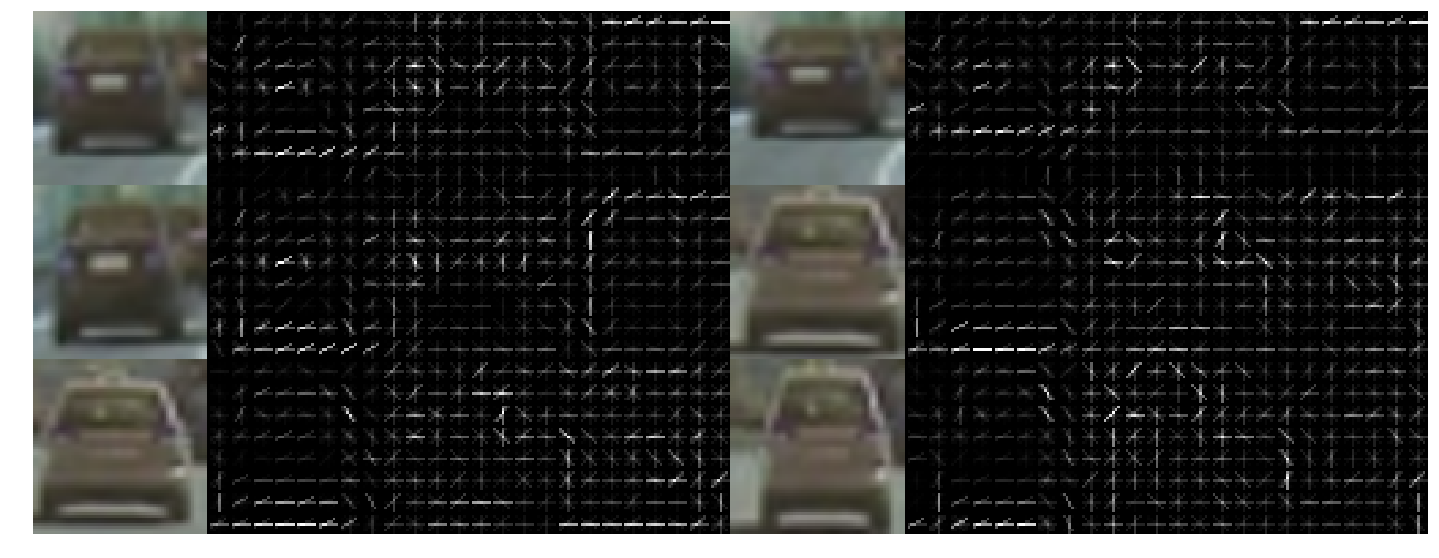

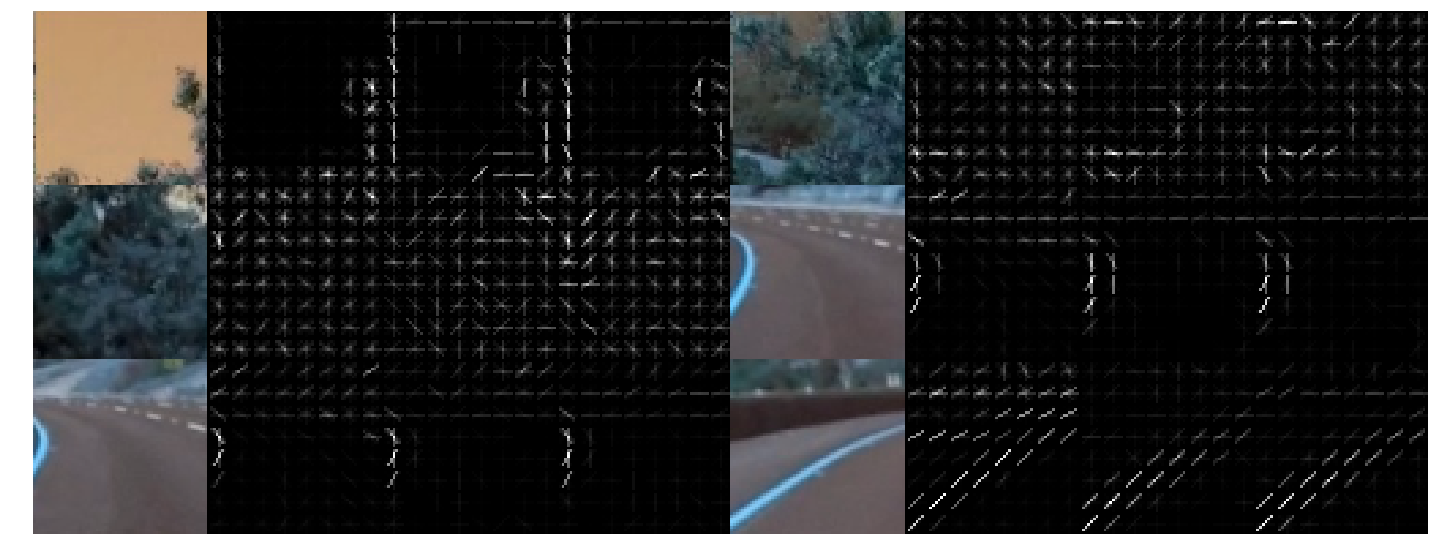

In [37]:
preview_cars = hog_images(files_cars[:6])
display_image_set(preview_cars, "hog_cars", cols_num=8)

preview_noncars = hog_images(files_noncars[:6])
display_image_set(preview_noncars, "hog_noncars", cols_num=8)

In [8]:
imgs = load_images(files_cars, num=100)

colorspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orientations = range(6, 13)
px_per_cells = range(6, 17)
cells_per_blocks = range(1, 4)
channels = [None, 0, 1, 2]

for space in colorspaces:
    for orientation in orientations:
        for px_per_cell in px_per_cells:
            for cells_per_block in cells_per_blocks:
                for channel in channels:
                    t = time.time()
                    hog_images(imgs, channel=channel, orient=orientation, pix_per_cell=px_per_cell, 
                                                   cell_per_block=cells_per_block, colorspace=space)
                    t2 = time.time()
                    print('Images: {} | Time: {}sec | Space {} | Orient {} | PPC {} | CPB {} | Channel {}'
                          .format(len(imgs), round(t2 - t, 2), space, orientation, px_per_cell, cells_per_block, channel))

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Images: 100 | Time: 19.65sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel None
Images: 100 | Time: 6.96sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 0
Images: 100 | Time: 6.76sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 1
Images: 100 | Time: 6.65sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 2
Images: 100 | Time: 20.54sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel None
Images: 100 | Time: 6.4sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 0
Images: 100 | Time: 6.65sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 1
Images: 100 | Time: 6.35sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 2
Images: 100 | Time: 24.58sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel None
Images: 100 | Time: 8.66sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 0
Images: 100 | Time: 8.64sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 1
Images: 100 | Time: 11.19sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 2
Images: 100 | Time: 21.11sec | Space RGB

Images: 100 | Time: 2.06sec | Space RGB | Orient 6 | PPC 14 | CPB 2 | Channel 1
Images: 100 | Time: 1.84sec | Space RGB | Orient 6 | PPC 14 | CPB 2 | Channel 2
Images: 100 | Time: 5.61sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel None
Images: 100 | Time: 1.82sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 0
Images: 100 | Time: 1.85sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 1
Images: 100 | Time: 2.38sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 2
Images: 100 | Time: 6.22sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel None
Images: 100 | Time: 2.03sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 0
Images: 100 | Time: 2.39sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 1
Images: 100 | Time: 1.92sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 2
Images: 100 | Time: 6.42sec | Space RGB | Orient 6 | PPC 15 | CPB 2 | Channel None
Images: 100 | Time: 2.43sec | Space RGB | Orient 6 | PPC 15 | CPB 2 | Channel 0
Images: 100 | Time: 2.14sec | S

Images: 100 | Time: 5.74sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel None
Images: 100 | Time: 1.54sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 0
Images: 100 | Time: 1.44sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 1
Images: 100 | Time: 1.54sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 2
Images: 100 | Time: 4.34sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel None
Images: 100 | Time: 1.43sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 0
Images: 100 | Time: 1.51sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 1
Images: 100 | Time: 2.1sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 2
Images: 100 | Time: 4.1sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel None
Images: 100 | Time: 1.08sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 0
Images: 100 | Time: 0.89sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 1
Images: 100 | Time: 1.41sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 2
Images: 100 | Time: 2.79sec | Spa

KeyboardInterrupt: 

In [5]:
features_cars = hog_preview(files_cars)
features_noncars = hog_preview(files_noncars)

X = np.vstack((features_cars, features_noncars)).astype(np.float64)
y = np.append(np.ones(len(features_cars)), np.zeros(len(features_noncars)))

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
print("Train features {}, labels {}".format(X_train.shape, y_train.shape))
print("Test features {}, labels {}".format(X_test.shape, y_test.shape))

KeyboardInterrupt: 

In [46]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy', round(svc.score(X_test, y_test), 4))

X = X_test[0:10]
y = y_test[0:10]
print('Prediction:', svc.predict(X))
print('True Label:', y)

Test Accuracy 0.9344
Prediction: [ 1.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
True Label: [ 1.  0.  0.  0.  0.  0.  1.  1.  1.  1.]


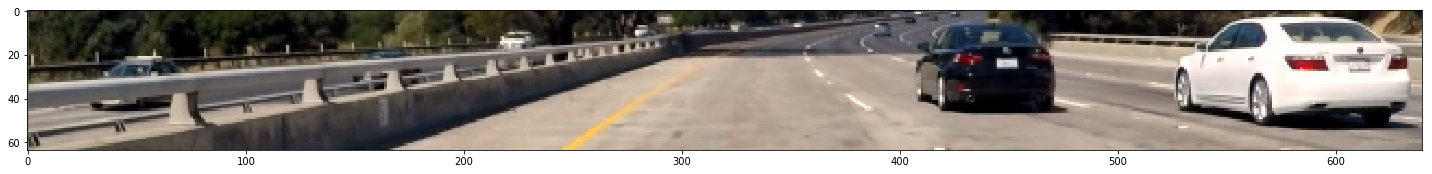

(1, 4704)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [69]:
def find_cars(img_init, bbox, svc, scaled_X, cps=2, show_all=False):
    rectangles = []
    ystart, ystop, scale = bbox
    
    img = np.copy(img_init)
    img = img.astype(np.float32) / 255.0
    img = img[ystart:ystop, :,:]
    
    if scale != 1:
        imshape = img.shape
        img = cv2.resize(img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    plt.figure(figsize=(25,25))
    plt.imshow(img)
    plt.show()
    
    orient=8
    ppc=8
    cpb=2
    window = 64
    
    nblocks_per_window = (window // ppc) - 1 
    nxblocks = (img.shape[1] // ppc) + 1
    nyblocks = (img.shape[0] // ppc) + 1
#     nfeat_per_block = orient*cell_per_block**2
    nxsteps = (nxblocks - nblocks_per_window) // cps
    nysteps = (nyblocks - nblocks_per_window) // cps
    features = hog_features(img)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cps
            xpos = xb * cps
            win_features = []
            
            for feature in features:
                win_feature = feature[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                win_features.append(win_feature)
                
            win_hog_features = np.hstack(tuple(win_features)).reshape(1, -1)
            print(win_features.shape)
            
            xleft = xpos * ppc
            ytop = ypos * ppc
            subimg = img[ytop:ytop+window, xleft:xleft+window]
            subimg = cv2.resize(subimg, (64,64))

            win_spatial_features = bin_spatial(subimg, size=(16, 16))
            print(win_spatial_features.shape)
            
            win_hist_features = color_hist(subimg, nbins=16)
            print(win_hist_features.shape)
            
            test_features = svc.transform(np.hstack((win_spatial_features, win_hist_features, win_hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(win_features)

            if test_prediction == 1 or show_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

test_img = mpimg.imread('./test_images/test1.jpg')
rectangles = []

# bbox1 = (464 - 64, 464, 1.0)
# rectangles.append(find_cars(test_img, bbox1, svc))

# bbox3 = (int(496 - 64 * 1.5), 496, 1.5)
# rectangles.append(find_cars(test_img, bbox3, svc))
# bbox4 = (432, 528, 1.5)
bbox5 = (400, 528, 2.0)
rects = find_cars(test_img, bbox5, svc, scaled_X)
rectangles.append(rects)
# bbox6 = (432, 560, 2.0)
# bbox7 = (400, 596, 3.5)
# bbox8 = (464, 660, 3.5)
# bboxes = [bbox1, bbox2, bbox3, bbox4, bbox5, bbox6, bbox7, bbox8]

# for bbox in bboxes:
#     rectangles.append(find_cars(test_img, bbox, svc))

# rectangles = [item for sublist in rectangles for item in sublist] 
# test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
# plt.figure(figsize=(10,10))
# plt.imshow(test_img_rects)
# plt.show()

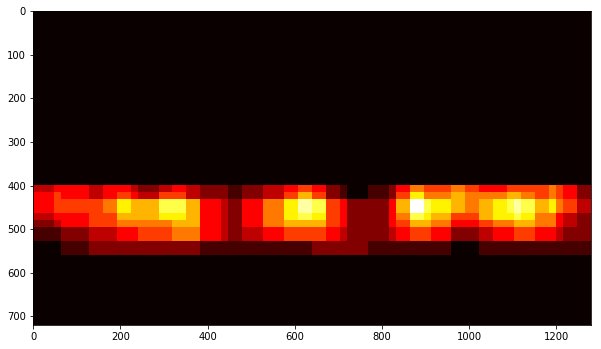

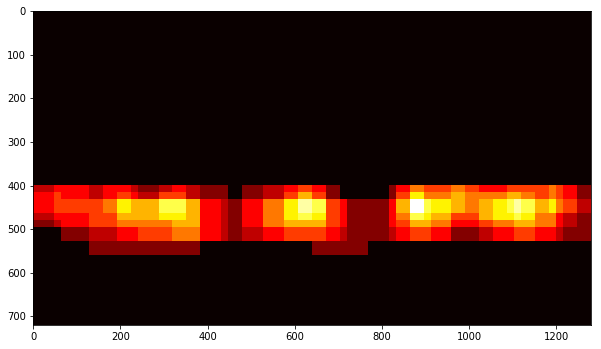

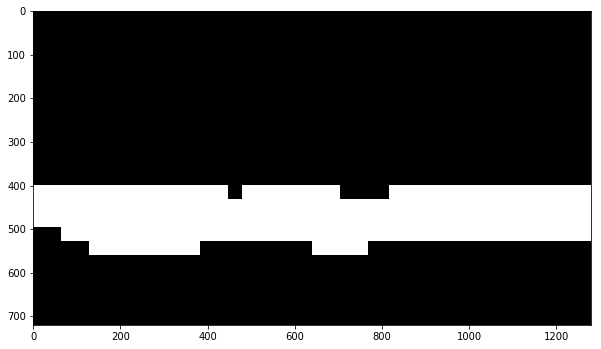

In [20]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
plt.show()

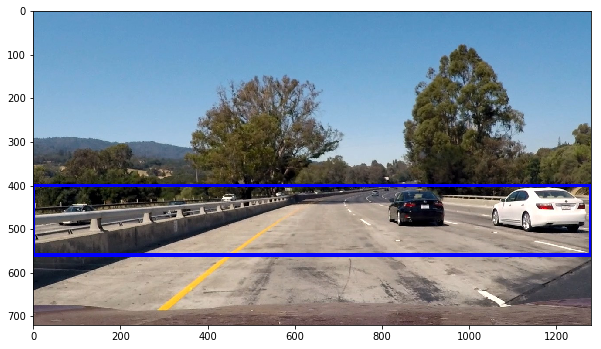

In [21]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.show()

In [17]:
def process_frame(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


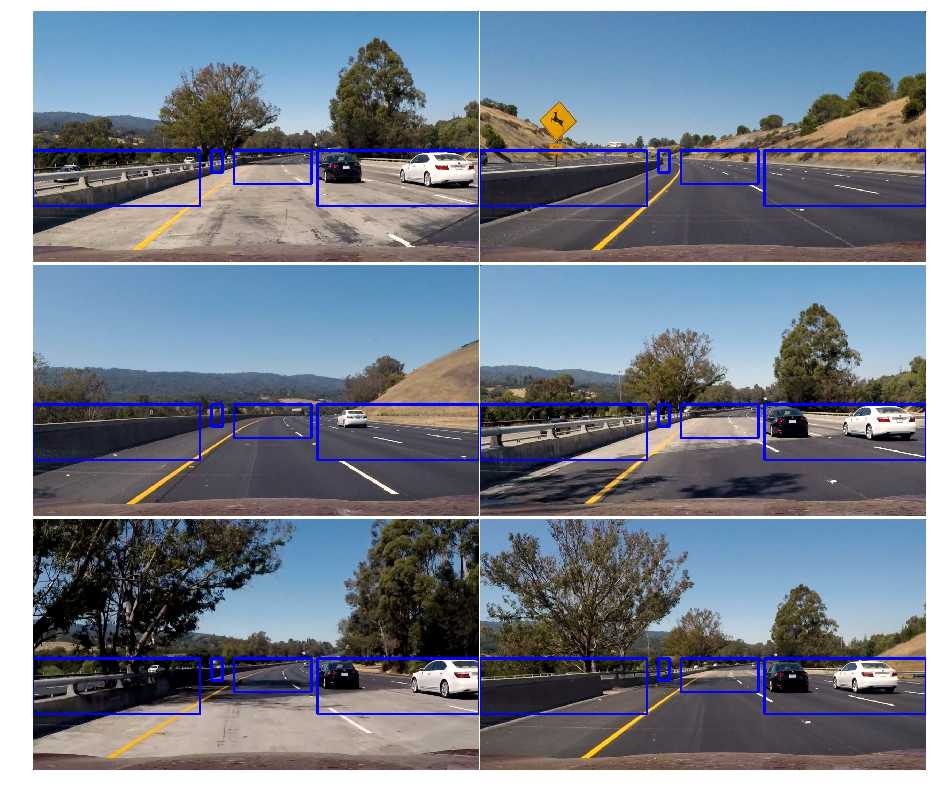

In [18]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')
    
plt.show()

In [22]:
test_out_file = './output_videos/test_video_out.mp4'
clip_test = VideoFileClip('./source_videos/test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video_out.mp4
[MoviePy] Writing video ./output_videos/test_video_out.mp4


 97%|█████████▋| 38/39 [00:32<00:00,  1.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video_out.mp4 

CPU times: user 18.7 s, sys: 3.23 s, total: 21.9 s
Wall time: 36.1 s


In [23]:

# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [24]:
def process_frame_for_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [25]:
det = Vehicle_Detect()

test_out_file2 = './output_videos/test_video_out.mp4'
clip_test2 = VideoFileClip('./source_videos/test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video_out.mp4
[MoviePy] Writing video ./output_videos/test_video_out.mp4


 97%|█████████▋| 38/39 [00:37<00:01,  1.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video_out.mp4 

CPU times: user 20.5 s, sys: 3.24 s, total: 23.8 s
Wall time: 42.2 s


In [26]:
det = Vehicle_Detect()

proj_out_file = './output_videos/project_video_out.mp4'
clip_proj = VideoFileClip('./source_videos/project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_out.mp4
[MoviePy] Writing video ./output_videos/project_video_out.mp4


 19%|█▉        | 240/1261 [04:20<18:49,  1.11s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 